In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import scipy.stats as stats


In [24]:
# Load the dataset
df = pd.read_csv(r'C:\Users\hp\Desktop\AIML Project\ship_fuel_efficiency.csv')

# Display basic information about the dataset
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ship_id             1440 non-null   object 
 1   ship_type           1440 non-null   object 
 2   route_id            1440 non-null   object 
 3   month               1440 non-null   object 
 4   distance            1440 non-null   float64
 5   fuel_type           1440 non-null   object 
 6   fuel_consumption    1440 non-null   float64
 7   CO2_emissions       1440 non-null   float64
 8   weather_conditions  1440 non-null   object 
 9   engine_efficiency   1440 non-null   float64
dtypes: float64(4), object(6)
memory usage: 112.6+ KB
None
          distance  fuel_consumption  CO2_emissions  engine_efficiency
count  1440.000000       1440.000000    1440.000000        1440.000000
mean    151.753354       4844.246535   13365.454882          82.582924
std     108.472230       4892.352

In [25]:
# Applying Kwon Cleaning Method with numeric conversion
def kwon_cleaning_method(df, threshold=3):
    df_numeric = df.select_dtypes(include=[np.number])  # Select only numeric columns
    z_scores = (df_numeric - df_numeric.mean()) / df_numeric.std()  # Compute Z-scores
    cleaned_df = df[(z_scores.abs() <= threshold).all(axis=1)]
    return cleaned_df

df = kwon_cleaning_method(df)

# Drop NaN values
df = df.dropna()

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 1399 entries, 0 to 1439
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ship_id             1399 non-null   object 
 1   ship_type           1399 non-null   object 
 2   route_id            1399 non-null   object 
 3   month               1399 non-null   object 
 4   distance            1399 non-null   float64
 5   fuel_type           1399 non-null   object 
 6   fuel_consumption    1399 non-null   float64
 7   CO2_emissions       1399 non-null   float64
 8   weather_conditions  1399 non-null   object 
 9   engine_efficiency   1399 non-null   float64
dtypes: float64(4), object(6)
memory usage: 120.2+ KB
None
          distance  fuel_consumption  CO2_emissions  engine_efficiency
count  1399.000000       1399.000000    1399.000000        1399.000000
mean    142.631144       4397.577784   12126.286004          82.592159
std      95.722821       4181.429098  

In [26]:
# Compute missing features(Feature Engineering)
df['speed'] = df['distance'] / 10  # Assuming constant time of 10 units
df['displacement'] = df['CO2_emissions'] * 0.1  # Using an estimated efficiency factor
df['power'] = df['engine_efficiency'] * df['fuel_consumption']
df['draft'] = df['displacement'] * 0.05  # Approximate draft estimation

print(df)

     ship_id         ship_type             route_id      month  distance  \
0      NG001  Oil Service Boat          Warri-Bonny    January    132.26   
1      NG001  Oil Service Boat  Port Harcourt-Lagos   February    128.52   
2      NG001  Oil Service Boat  Port Harcourt-Lagos      March     67.30   
3      NG001  Oil Service Boat  Port Harcourt-Lagos      April     71.68   
4      NG001  Oil Service Boat          Lagos-Apapa        May    134.32   
...      ...               ...                  ...        ...       ...   
1435   NG120   Fishing Trawler  Port Harcourt-Lagos     August     63.84   
1436   NG120   Fishing Trawler          Lagos-Apapa  September     61.43   
1437   NG120   Fishing Trawler  Port Harcourt-Lagos    October    193.09   
1438   NG120   Fishing Trawler          Lagos-Apapa   November    166.50   
1439   NG120   Fishing Trawler          Warri-Bonny   December    127.66   

     fuel_type  fuel_consumption  CO2_emissions weather_conditions  \
0          HFO   

In [27]:
# Selecting relevant features (excluding categorical weather_conditions)
features = ['speed', 'draft', 'displacement', 'power']
target = 'fuel_consumption'

# Splitting the dataset into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
# Scaling features using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


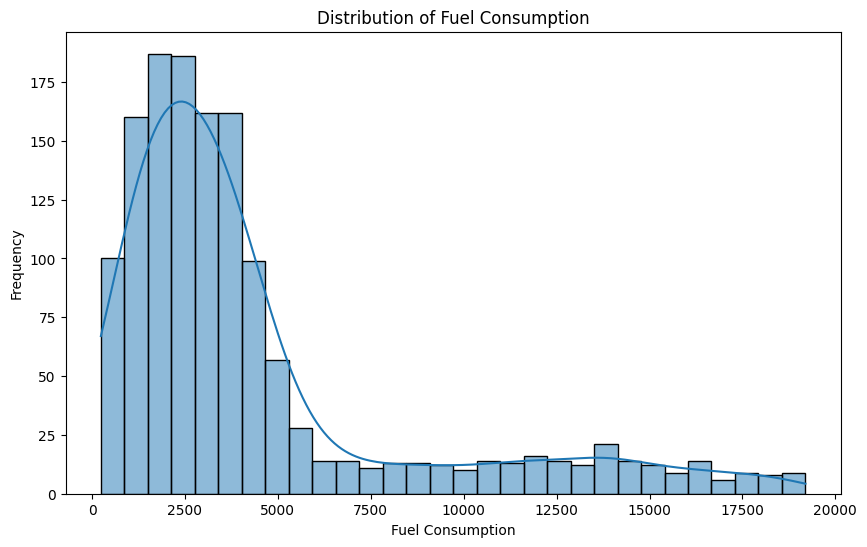

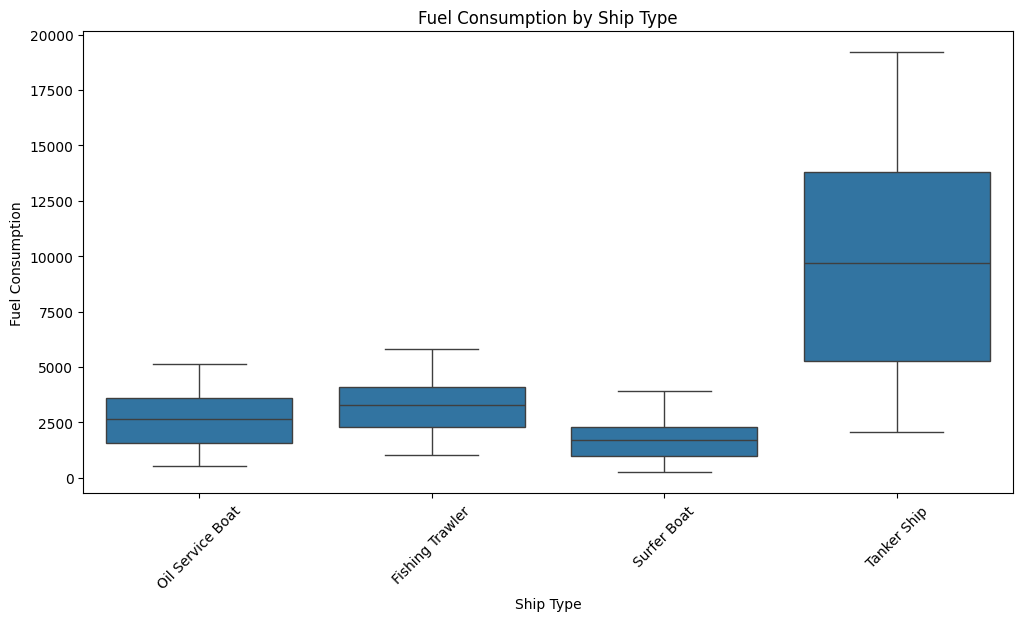

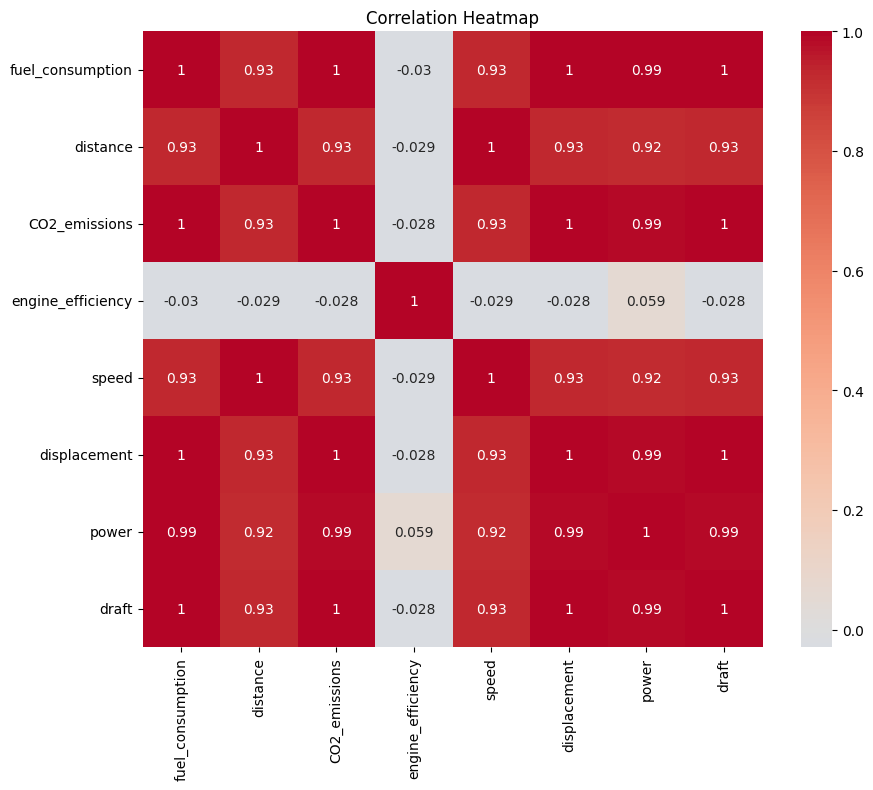

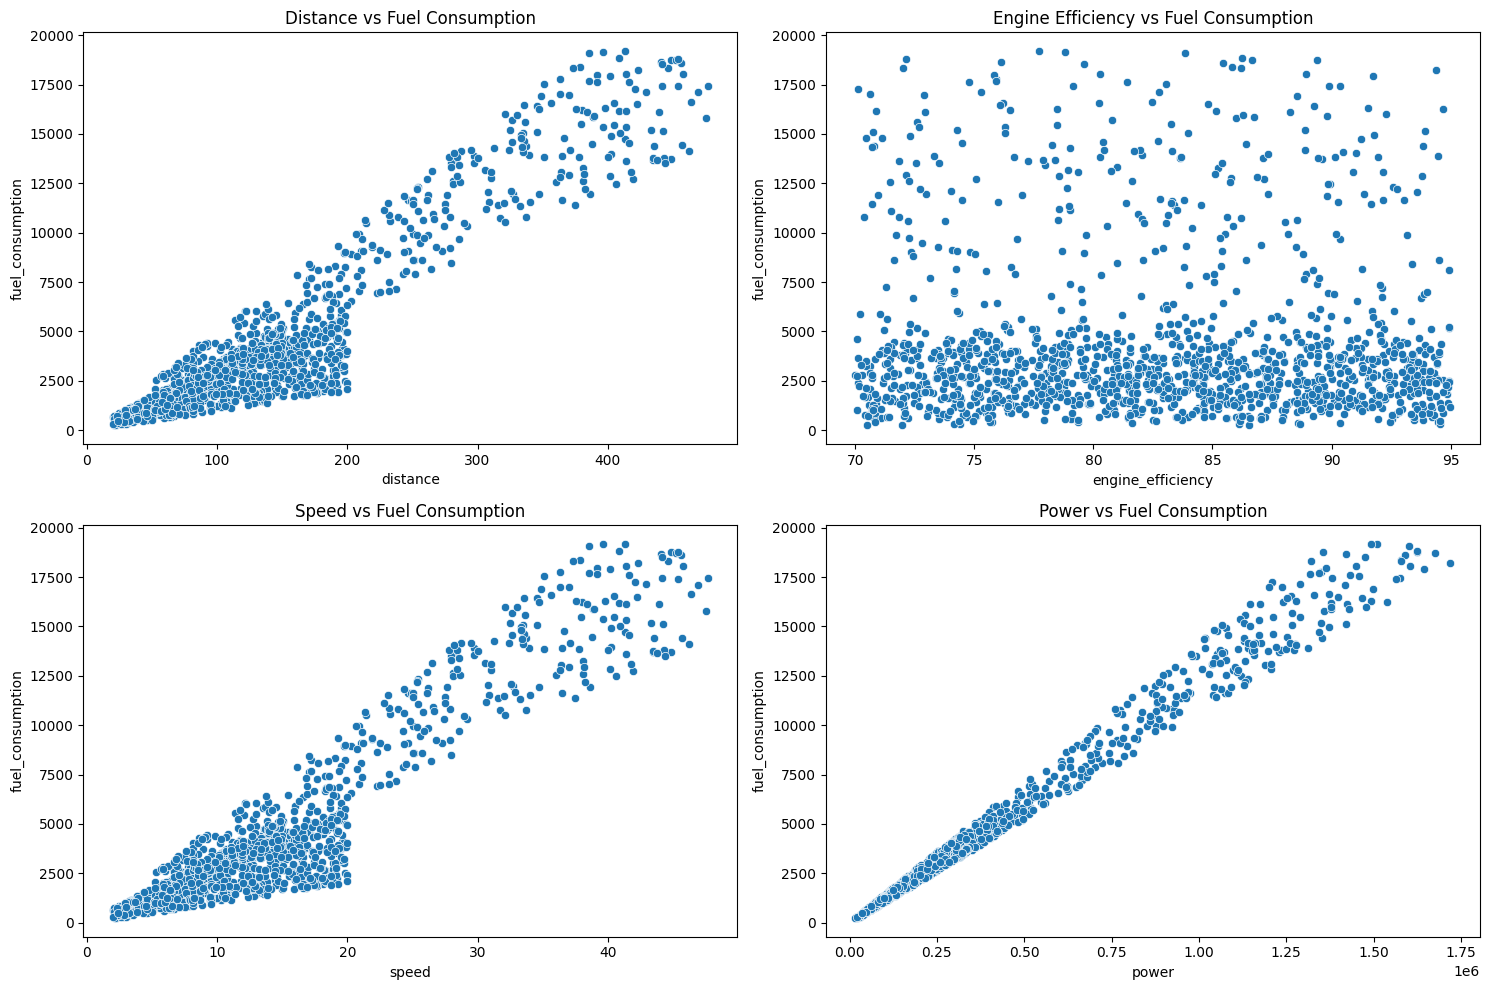

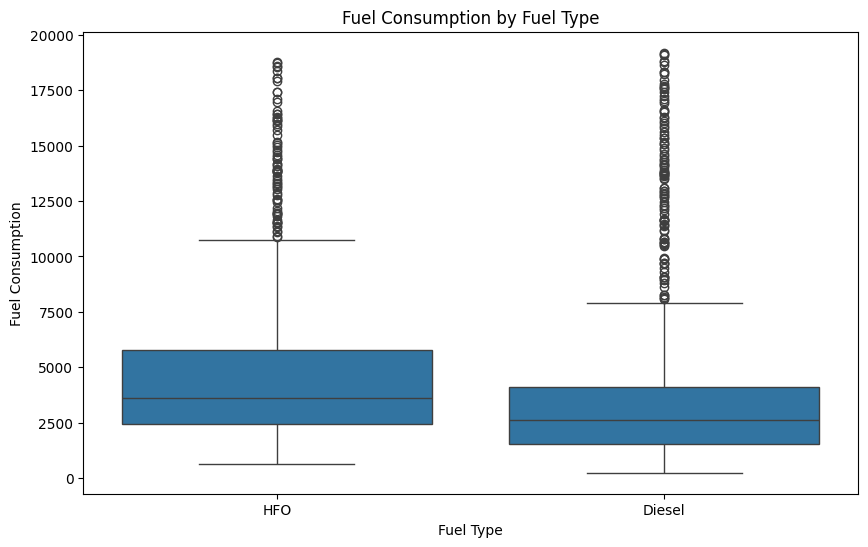

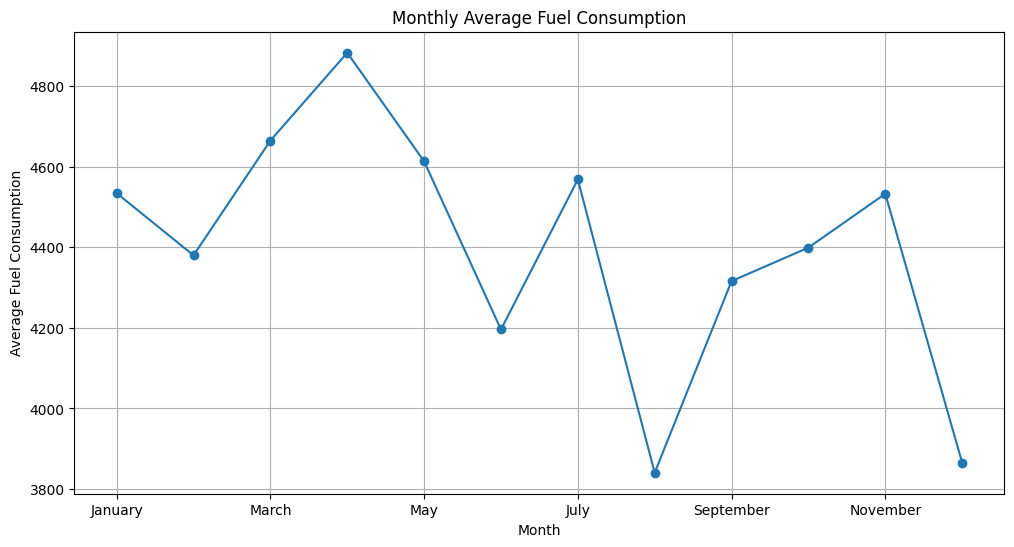

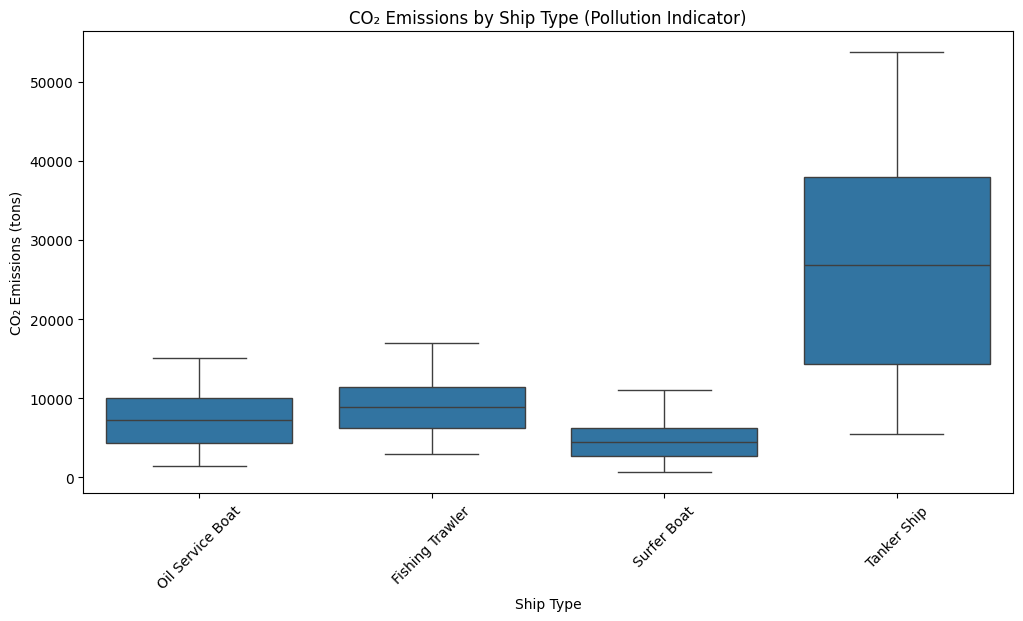

In [29]:
# 1. Distribution of Fuel Consumption
plt.figure(figsize=(10, 6))
sns.histplot(df['fuel_consumption'], bins=30, kde=True)
plt.title('Distribution of Fuel Consumption')
plt.xlabel('Fuel Consumption')
plt.ylabel('Frequency')
plt.show()

# 2. Fuel Consumption by Ship Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='ship_type', y='fuel_consumption', data=df)
plt.title('Fuel Consumption by Ship Type')
plt.xlabel('Ship Type')
plt.ylabel('Fuel Consumption')
plt.xticks(rotation=45)
plt.show()

# 3. Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[['fuel_consumption', 'distance', 'CO2_emissions', 
                 'engine_efficiency', 'speed', 'displacement', 'power', 'draft']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

# 4. Scatter Plots of Key Features vs Fuel Consumption
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(ax=axes[0, 0], x='distance', y='fuel_consumption', data=df)
axes[0, 0].set_title('Distance vs Fuel Consumption')

sns.scatterplot(ax=axes[0, 1], x='engine_efficiency', y='fuel_consumption', data=df)
axes[0, 1].set_title('Engine Efficiency vs Fuel Consumption')

sns.scatterplot(ax=axes[1, 0], x='speed', y='fuel_consumption', data=df)
axes[1, 0].set_title('Speed vs Fuel Consumption')

sns.scatterplot(ax=axes[1, 1], x='power', y='fuel_consumption', data=df)
axes[1, 1].set_title('Power vs Fuel Consumption')

plt.tight_layout()
plt.show()

# 5. Fuel Consumption by Fuel Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel_type', y='fuel_consumption', data=df)
plt.title('Fuel Consumption by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Fuel Consumption')
plt.show()

# 6. Monthly Fuel Consumption Trends
plt.figure(figsize=(12, 6))
monthly_avg = df.groupby('month')['fuel_consumption'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])
monthly_avg.plot(kind='line', marker='o')
plt.title('Monthly Average Fuel Consumption')
plt.xlabel('Month')
plt.ylabel('Average Fuel Consumption')
plt.grid(True)
plt.show()

# 7. CO2 Emissions by Ship Type (Pollution / Greenhouse Gas)
plt.figure(figsize=(12, 6))
sns.boxplot(x='ship_type', y='CO2_emissions', data=df)
plt.title('CO₂ Emissions by Ship Type (Pollution Indicator)')
plt.xlabel('Ship Type')
plt.ylabel('CO₂ Emissions (tons)')
plt.xticks(rotation=45)
plt.show()


In [30]:
# White-box model: Fuel Consumption Formula-Based Model (from research paper)
def fuel_consumption_model(X):
    speed, draft, displacement, power = X.T
    return (0.6 * speed**1.2 + 0.25 * draft**0.8 + 
            0.15 * displacement**0.5 + 0.5 * power**1.1)
    
    
y_pred_whitebox = fuel_consumption_model(X_test)


In [31]:
# Black-box model: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Black-box model: XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


In [32]:
# Evaluating the models
def evaluate_model(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'\nModel: {model_name}')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R^2 Score: {r2}')

evaluate_model(y_test, y_pred_whitebox, "Fuel Consumption Formula (White-box)")
evaluate_model(y_test, y_pred_rf, "Random Forest (Black-box)")
evaluate_model(y_test, y_pred_xgb, "XGBoost (Black-box)")



Model: Fuel Consumption Formula (White-box)
MAE: 4576.286519821347
MSE: 38214004.79351887
RMSE: 6181.747713512649
R^2 Score: -1.2122117885397827

Model: Random Forest (Black-box)
MAE: 181.7122964285713
MSE: 73171.67964828953
RMSE: 270.50264259021486
R^2 Score: 0.9957640856230631

Model: XGBoost (Black-box)
MAE: 177.8076922956194
MSE: 76177.09523027817
RMSE: 276.0019841056911
R^2 Score: 0.9955901018750665


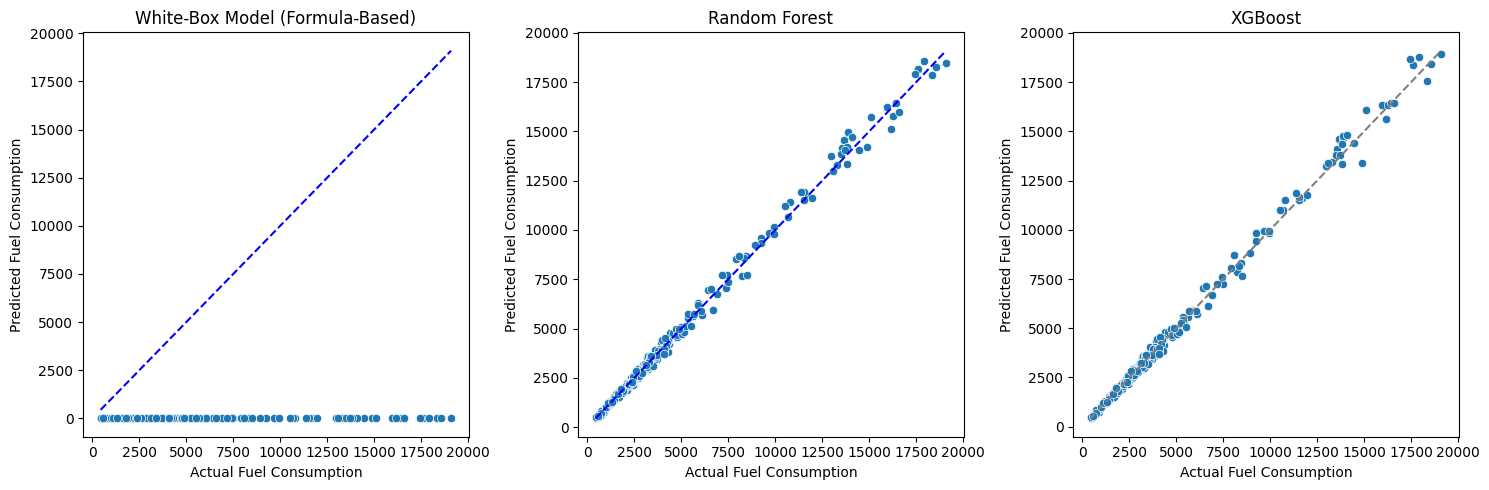

In [33]:
# Visualizing actual vs predicted fuel consumption for different models
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.scatterplot(x=y_test, y=y_pred_whitebox)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='blue')
plt.xlabel("Actual Fuel Consumption")
plt.ylabel("Predicted Fuel Consumption")
plt.title("White-Box Model (Formula-Based)")

plt.subplot(1,3,2)
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='blue')
plt.xlabel("Actual Fuel Consumption")
plt.ylabel("Predicted Fuel Consumption")
plt.title("Random Forest")

plt.subplot(1,3,3)
sns.scatterplot(x=y_test, y=y_pred_xgb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray')
plt.xlabel("Actual Fuel Consumption")
plt.ylabel("Predicted Fuel Consumption")
plt.title("XGBoost")

plt.tight_layout()
plt.show()


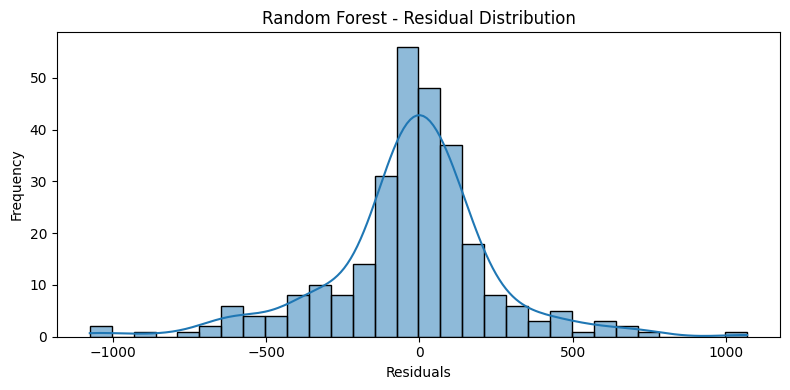

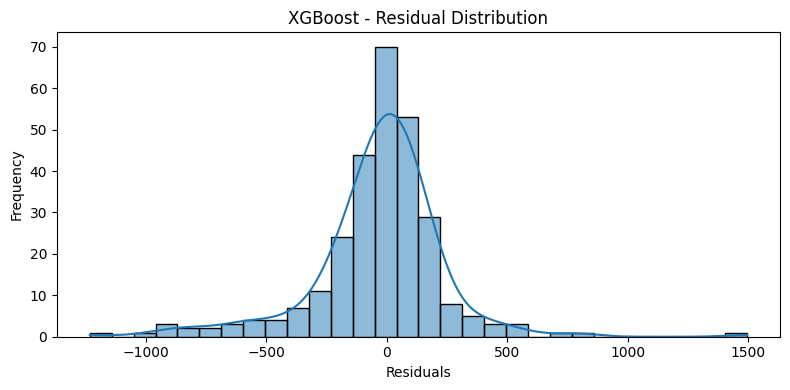

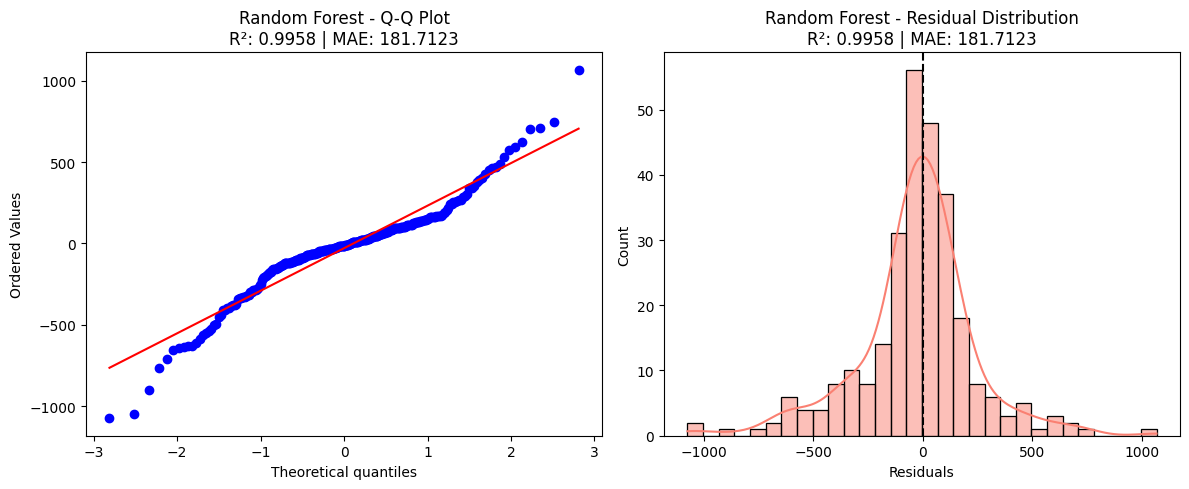

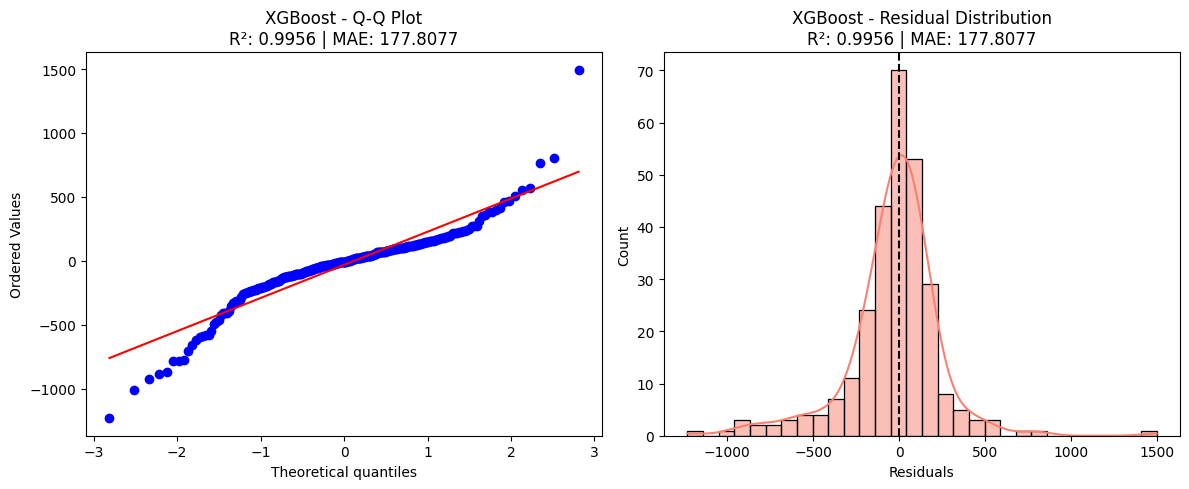

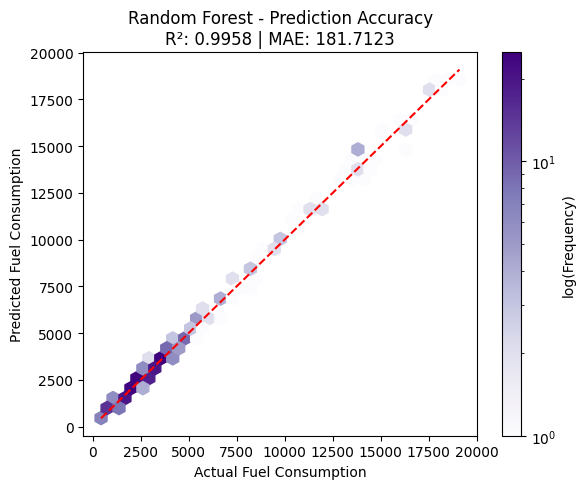

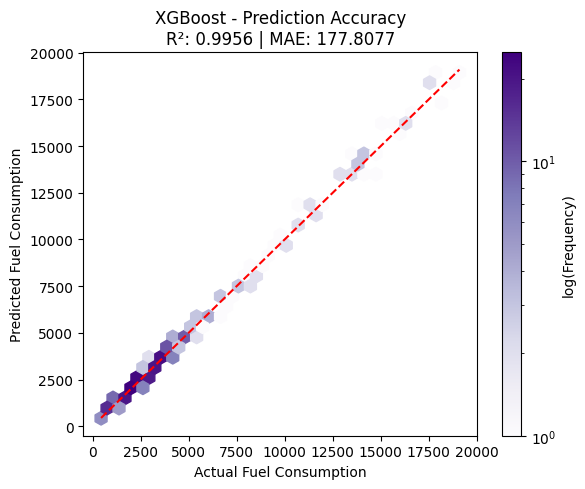

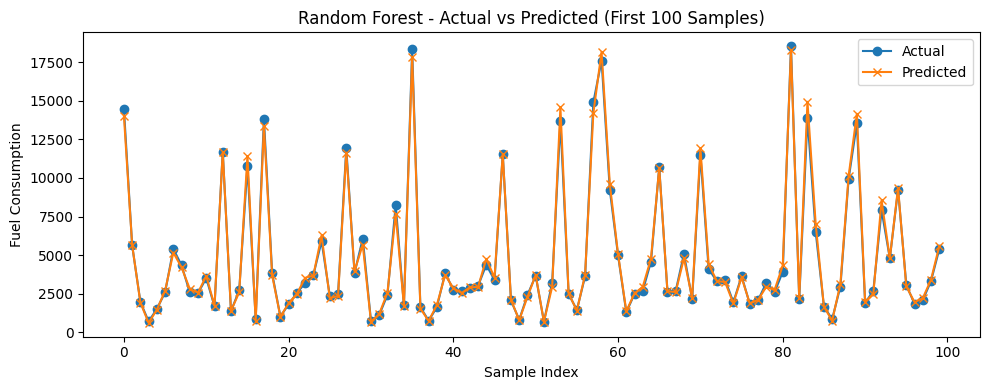

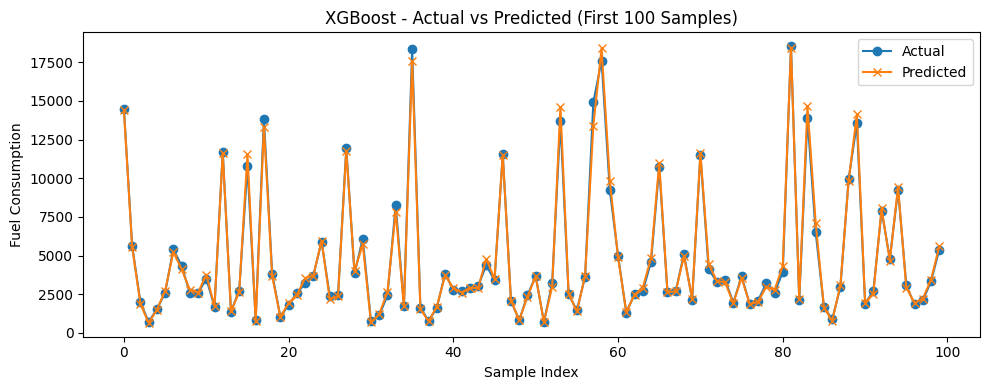

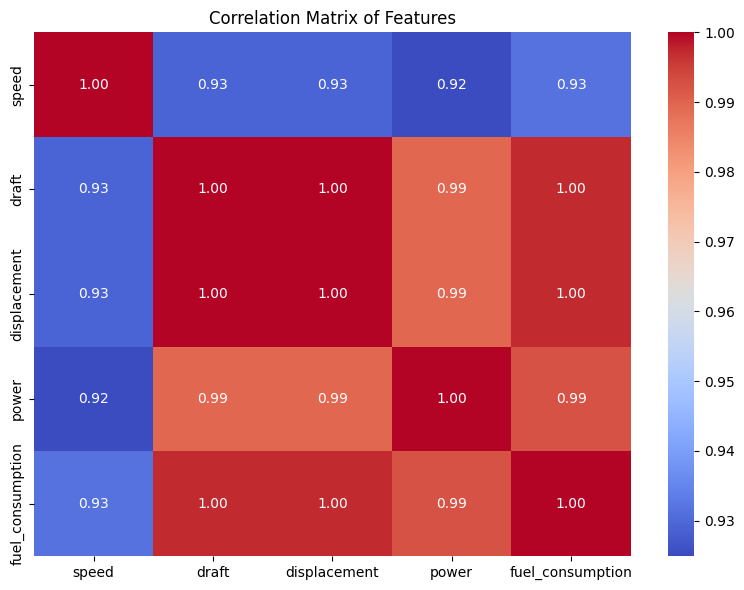

In [34]:
# 1. Feature Importance Plot (Random Forest and XGBoost)
def plot_feature_importance(model, features, model_name):
    importances = model.feature_importances_
    feature_data = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(8, 5))
    colors = sns.color_palette("viridis", len(feature_data))
    sns.barplot(x="Importance", y="Feature", data=feature_data, palette=colors)

    for i, (imp, feat) in enumerate(zip(feature_data['Importance'], feature_data['Feature'])):
        plt.text(imp + 0.001, i, f'{imp:.3f}', va='center')

    plt.title(f'{model_name} - Feature Importance', fontsize=14)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# 2. Residual Analysis
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f'{model_name} - Residual Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_residuals(y_test, y_pred_rf, "Random Forest")
plot_residuals(y_test, y_pred_xgb, "XGBoost")

# 3. Q-Q Plot for Normality Check of Residuals
def qq_and_residual_plot(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=axes[0])
    axes[0].set_title(f"{model_name} - Q-Q Plot\nR²: {r2:.4f} | MAE: {mae:.4f}")

    # Residual histogram + KDE
    sns.histplot(residuals, kde=True, ax=axes[1], color="salmon", bins=30)
    axes[1].axvline(0, linestyle='--', color='black')
    axes[1].set_title(f"{model_name} - Residual Distribution\nR²: {r2:.4f} | MAE: {mae:.4f}")
    axes[1].set_xlabel("Residuals")

    plt.tight_layout()
    plt.show()

qq_and_residual_plot(y_test, y_pred_rf, "Random Forest")
qq_and_residual_plot(y_test, y_pred_xgb, "XGBoost")


def regression_hexbin(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.hexbin(y_true, y_pred, gridsize=30, cmap="Purples", bins='log')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', linewidth=1.5)
    plt.colorbar(label='log(Frequency)')
    plt.xlabel("Actual Fuel Consumption")
    plt.ylabel("Predicted Fuel Consumption")
    plt.title(f"{model_name} - Prediction Accuracy\nR²: {r2:.4f} | MAE: {mae:.4f}")
    plt.tight_layout()
    plt.show()

regression_hexbin(y_test, y_pred_rf, "Random Forest")
regression_hexbin(y_test, y_pred_xgb, "XGBoost")


# 5. Predicted vs. Actual Line Plot
def line_plot_comparison(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.values[:100], label='Actual', marker='o')
    plt.plot(y_pred[:100], label='Predicted', marker='x')
    plt.title(f"{model_name} - Actual vs Predicted (First 100 Samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("Fuel Consumption")
    plt.legend()
    plt.tight_layout()
    plt.show()

line_plot_comparison(y_test, y_pred_rf, "Random Forest")
line_plot_comparison(y_test, y_pred_xgb, "XGBoost")

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[features + [target]].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()


